In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
from pycbc.waveform.waveform_modes import get_glm #(l, m, theta)
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#
import matplotlib.pyplot as plt

In [2]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

# Extracting (2,2) mode

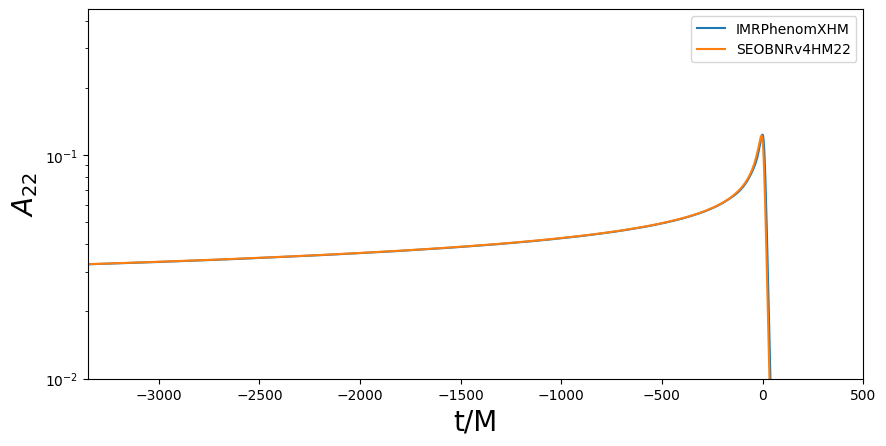

In [3]:
M=40
q=2
delta_t=1./4096
M1=q*M/(1+q)
M2=M/(1+q)
fmin=20
angle=(np.pi/180)*60
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
#mode2polfac=4*(5/(64*np.pi))**(1/2)   
#apx=['IMRPhenomXHM','SEOBNRv4HM']


#Both the Phenom and EOB curve appear the same.
sp,sc = get_td_waveform(approximant='IMRPhenomXHM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[2,2]])
sp1,sc1 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=0, mode_array=[[2,2]])
#sp2,sc2 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=np.pi, mode_array=[[2,2]])
#spa,scb = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[2,2]])

h22Imr = sp+1j*sc
h22Imr1 = (sp1+1j*sc1)*((1+np.cos(angle))**2)/4 #multiply suitable inc factors with zero inc data to get inc effects
#h22Imr2 = (sp2+1j*sc2)*((1-np.cos(angle))**2)/4 #new
#h22IMR = spa+1j*scb
plt.figure(figsize=(10,4.8))
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.ylim(ymax=4.5e-1)
plt.ylim(ymin=1e-2)
plt.xlabel('t/M',size=20)
plt.ylabel(r'$A_{22}$',size=20)
plt.yscale('log')
plt.plot(sp.sample_times/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="IMRPhenomXHM")
#plt.plot(spa.sample_times/(M*MTSUN_SI),abs(h22IMR)/(G_SI*M_SI/D_SI/C_SI/C_SI),linewidth =4,label="EOB")
plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h22Imr1)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM22")
#plt.plot(sp2.sample_times/(M*MTSUN_SI),abs(h22Imr2)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HMM2-2")
#plt.plot(sp2.sample_times/(M*MTSUN_SI),abs(h22Imr2+h22Imr1)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="totalEOB")
plt.legend()

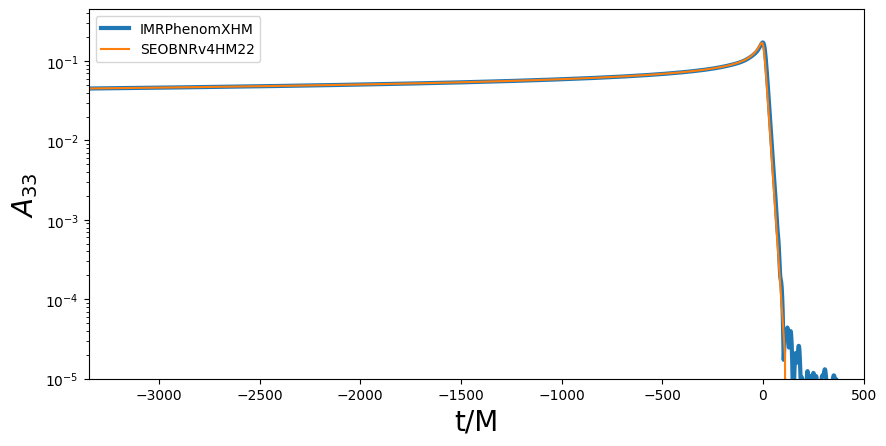

In [15]:
M=40
q=2
delta_t=1./4096
M1=q*M/(1+q)
M2=M/(1+q)
fmin=20
angle=(np.pi/180)*40
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
#mode3polfac=4*(5/(64*np.pi))**(1/2)   
#apx=['IMRPhenomXHM','SEOBNRv4HM']


#Both the Phenom and EOB curve appear same apart from an overall phase factor (True for any mode).
sp,sc = get_td_waveform(approximant='IMRPhenomXHM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[2,2]])
h22Imr = sp+1j*sc

sp1,sc1 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[2,2]])
h1 = sp1+1j*sc1

sp2,sc2 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=np.pi-angle, mode_array=[[2,2]])
h2 = sp2+1j*sc2

Y22,Y2_2 = sph_harmonics(angle,2)
h22ImR = Y22*(h1*Y22-h2*Y2_2)/(Y22**2-Y2_2**2)

#print(len(h22Imr))
#print(len(h22ImR))
plt.figure(figsize=(10,4.8))
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.ylim(ymax=4.5e-1)
plt.ylim(ymin=1e-5)
plt.xlabel('t/M',size=20)
plt.ylabel(r'$A_{33}$',size=20)
plt.yscale('log')
plt.plot(sp.sample_times/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI),linewidth=3,label="IMRPhenomXHM")
#plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h1)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM")
plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h22ImR)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM22")
plt.legend()

In [5]:
#?get_td_waveform_modes

In [6]:
# find y22 from hp,hc without setting inc = 0. Do it analytically and then using the numerical output of seobnr

0.0
0.47313675694193275
-0.019187526912170485


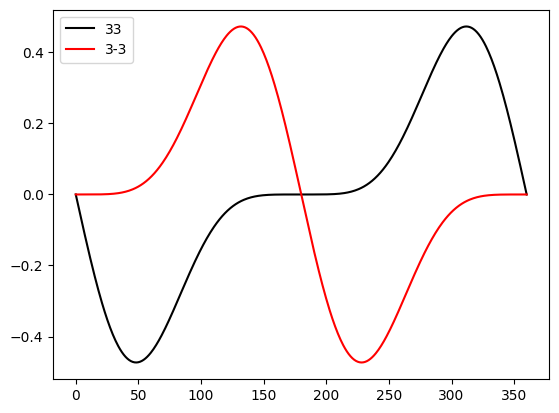

In [7]:
theta=np.linspace(0,360,500)
Y33=[]
Y3_3=[]
for th in theta:
    Y33.append(get_glm(3,3,(np.pi/180)*th))
    Y3_3.append(get_glm(3,-3,(np.pi/180)*th))
plt.plot(theta,Y33,'k-',label='33')
plt.plot(theta,Y3_3,'r-',label='3-3')
ind = np.where(around(Y3_3,2)==0)[0][0]
print(theta[ind])
print(Y33[432])
print(Y3_3[432])
#et_glm(2,-2,theta[250])
plt.legend()

# Extracting (3,3) mode

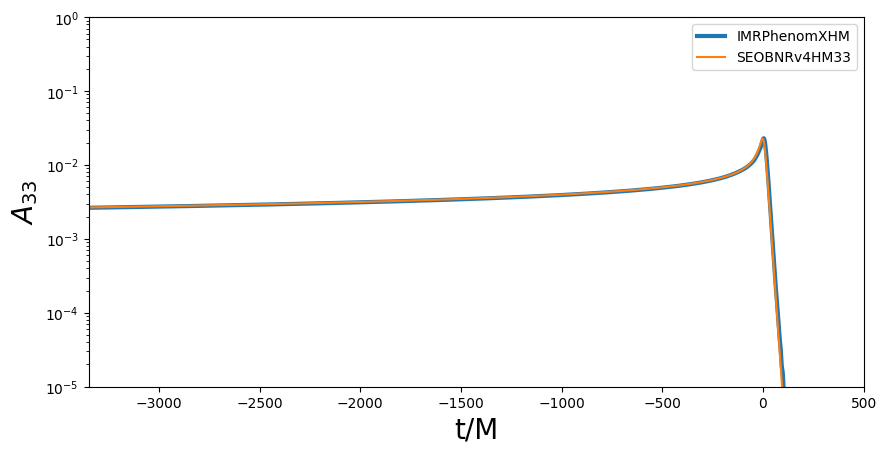

In [13]:
M=40
q=2
delta_t=1./4096
M1=q*M/(1+q)
M2=M/(1+q)
fmin=20
angle=(np.pi/180)*60
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
#mode3polfac=4*(5/(64*np.pi))**(1/2)   
#apx=['IMRPhenomXHM','SEOBNRv4HM']


#Both the Phenom and EOB curve appear the same.
sp,sc = get_td_waveform(approximant='IMRPhenomXHM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[3,3]])
h22Imr = sp+1j*sc

sp1,sc1 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[3,3]])
h1 = sp1+1j*sc1

sp2,sc2 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=np.pi-angle, mode_array=[[3,3]])
h2 = sp2+1j*sc2

Y33,Y3_3 = sph_harmonics(angle,3)
h22ImR = Y33*(h1*Y33+h2*Y3_3)/(Y33**2-Y3_3**2)  #Remember pycbc returns Y33*h33 for individual mode output

#print(len(h22Imr))
#print(len(h22ImR))
plt.figure(figsize=(10,4.8))
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
#plt.ylim(ymax=4.5e-1)
plt.ylim(ymin=1e-5)
plt.xlabel('t/M',size=20)
plt.ylabel(r'$A_{33}$',size=20)
plt.yscale('log')
plt.plot(sp.sample_times/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI),linewidth=3,label="IMRPhenomXHM")
#plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h1)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM")
plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h22ImR)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM33")
plt.legend()

# Extracting (4,4) mode

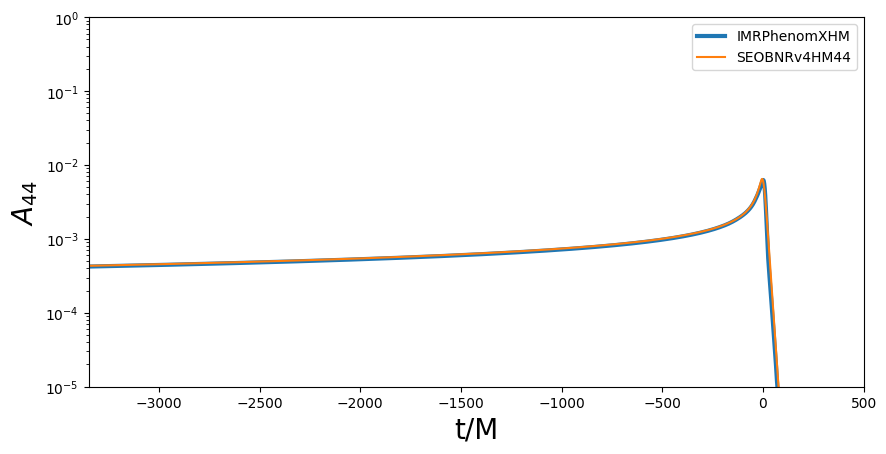

In [14]:
M=40
q=2
delta_t=1./4096
M1=q*M/(1+q)
M2=M/(1+q)
fmin=20
angle=(np.pi/180)*89
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
#mode3polfac=4*(5/(64*np.pi))**(1/2)   
#apx=['IMRPhenomXHM','SEOBNRv4HM']


#Both the Phenom and EOB curve appear same apart from an overall phase factor (True for any mode).
sp,sc = get_td_waveform(approximant='IMRPhenomXHM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[4,4]])
h22Imr = sp+1j*sc

sp1,sc1 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[4,4]])
h1 = sp1+1j*sc1

sp2,sc2 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=np.pi-angle, mode_array=[[4,4]])
h2 = sp2+1j*sc2

Y44,Y4_4 = sph_harmonics(angle,4)
h22ImR = Y44*(h1*Y44-h2*Y4_4)/(Y44**2-Y4_4**2)

#print(len(h22Imr))
#print(len(h22ImR))
plt.figure(figsize=(10,4.8))
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
#plt.ylim(ymax=4.5e-1)
plt.ylim(ymin=1e-5)
plt.xlabel('t/M',size=20)
plt.ylabel(r'$A_{44}$',size=20)
plt.yscale('log')
plt.plot(sp.sample_times/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI),linewidth =3 ,label="IMRPhenomXHM")
#plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h1)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM")
plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h22ImR)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM44")
plt.legend()

# Extracting (5,5) mode

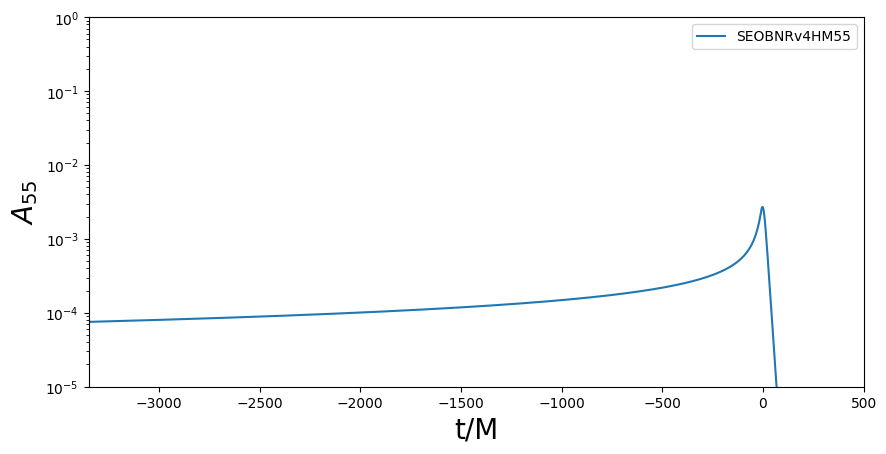

In [10]:
M=40
q=2
delta_t=1./4096
M1=q*M/(1+q)
M2=M/(1+q)
fmin=20
angle=(np.pi/180)*89
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
#mode3polfac=4*(5/(64*np.pi))**(1/2)   
#apx=['IMRPhenomXHM','SEOBNRv4HM']


#PhenomXHM doesn't have 5,5 mode
#sp,sc = get_td_waveform(approximant='IMRPhenomXHM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[4,4]])
#h22Imr = sp+1j*sc

sp1,sc1 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=angle, mode_array=[[5,5]])
h1 = sp1+1j*sc1

sp2,sc2 = get_td_waveform(approximant='SEOBNRv4HM', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, inclination=np.pi-angle, mode_array=[[5,5]])
h2 = sp2+1j*sc2

Y55,Y5_5 = sph_harmonics(angle,5)
h22ImR = Y55*(h1*Y55+h2*Y5_5)/(Y55**2-Y5_5**2)

#print(len(h22Imr))
#print(len(h22ImR))
plt.figure(figsize=(10,4.8))
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
#plt.ylim(ymax=4.5e-1)
plt.ylim(ymin=1e-5)
plt.xlabel('t/M',size=20)
plt.ylabel(r'$A_{55}$',size=20)
plt.yscale('log')
#plt.plot(sp.sample_times/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="IMRPhenomXHM")
#plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h1)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM")
plt.plot(sp1.sample_times/(M*MTSUN_SI),abs(h22ImR)/(G_SI*M_SI/D_SI/C_SI/C_SI),label="SEOBNRv4HM55")
plt.legend()